In [7]:
import os
import sys
from copy import deepcopy

import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import torch
from gymnasium.wrappers import RescaleAction
from torch import nn
from torch.distributions import Normal
from torch.optim import Adam

sys.path.append(os.path.abspath(".."))

from rlib.common.evaluation import get_trajectory, validation
from rlib.common.logger import TensorBoardLogger

%load_ext autoreload
%autoreload 2

In [3]:
env = gym.make("Pendulum-v1")

In [8]:
env = gym.make("Pendulum-v1", render_mode="rgb_array")

min_action, max_action = -1, 1
env = RescaleAction(env, min_action, max_action)

### DDPG

In [9]:
class OrnsteinUhlenbeckNoise:
    def __init__(self, shape, alpha: float = 0.15, sigma: float = 0.2):
        self.shape = shape
        self.alpha = alpha
        self.sigma = sigma

        self.loc = torch.zeros(shape, dtype=torch.float32)
        self.scale = sigma * torch.ones(shape, dtype=torch.float32)
        self.dist = Normal(self.loc, self.scale)

        self.reset()

    def sample(self):
        self.state = self.alpha * self.state + self.dist.sample()
        return self.state

    def reset(self):
        self.state = torch.zeros(self.shape)

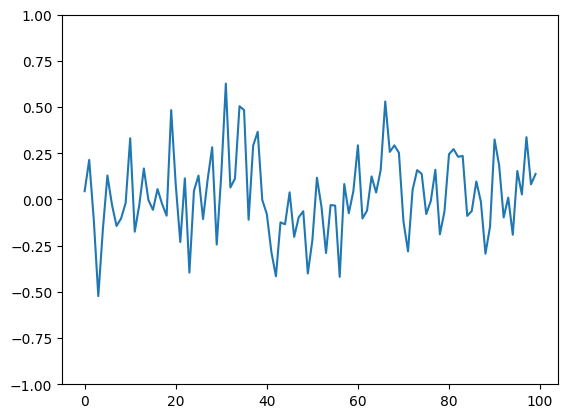

In [10]:
t = np.arange(100)
noise = np.zeros_like(t, dtype=np.float32)
ou_noise = OrnsteinUhlenbeckNoise((1,))

for i in range(t.size):
    noise[i] = ou_noise.sample().numpy()[0]

plt.ylim((-1, 1))
plt.plot(t, noise)

In [11]:
class DeterministicMlpPolicy(nn.Module):
    def __init__(
        self, obs_dim, action_dim, hidden_size=256, noise=OrnsteinUhlenbeckNoise
    ):
        super().__init__()
        self.obs_dim = obs_dim
        self.action_dim = action_dim
        self.hidden_size = hidden_size

        self.shape = (1, self.action_dim)
        self.noise = noise(self.shape)

        self.net = nn.Sequential(
            nn.Linear(obs_dim, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, action_dim),
        )

    def forward(self, input):
        """
        Args:
            input (torch.Tensor): (B, obs_dim)

        Returns:
            output: (torch.Tensor): (B, action_dim)
        """
        output = torch.tanh(self.net(input))
        return output

    def get_action(self, input, deterministic=False):
        """
        Args:
            input (torch.Tensor): (B, obs_dim)

        Returns:
            action: (torch.Tensor): (B, action_dim)
            log_prob_action: (torch.Tensor): (B, 1)
        """
        action = self.forward(input)

        if not deterministic:
            epsilon = self.noise.sample()
            action += epsilon

        return action

    def predict(self, observation, action=None, deterministic=False):
        """
        Called for env observation

        Args:
            observation (np.ndarray): (obs_dim,)

        Returns:
            action: (np.ndarray): (action_dim,)
            log_prob_action: (torch.Tensor): (1, 1)
        """

        expected_shape = (self.obs_dim,)
        if observation.shape != (self.obs_dim,):
            raise ValueError(
                f"Expected shape {expected_shape}, but got {observation.shape}"
            )

        input = torch.FloatTensor(observation.reshape(1, self.obs_dim))

        action = self.get_action(input, deterministic)
        action = action.detach().numpy()
        action = action.reshape((self.action_dim,))

        return action, {}

In [12]:
class MlpQCritic(nn.Module):
    def __init__(self, obs_dim, action_dim, hidden_size=256):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim + action_dim, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1),
        )

    def forward(self, observations, actions):
        """
        Args:
            observations (torch.Tensor): (B, obs_dim)
            actions (torch.Tensor): (B, action_dim)

        Returns:
            q_values: (torch.Tensor): (B, 1)
        """
        input = torch.cat((observations, actions), dim=1)
        return self.net(input)

In [13]:
class ReplayBuffer:
    def __init__(
        self,
        obs_dim,
        action_dim,
        max_size: int = 10000,
    ):
        self.max_size = max_size

        self.size = 0
        self.pointer = 0
        self.old_done = 0
        self.new_done = 0
        self.curr_obs = None

        self.observations = np.zeros((max_size, obs_dim))
        self.next_observations = np.zeros((max_size, obs_dim))
        self.actions = np.zeros((max_size, action_dim))
        self.rewards = np.zeros((max_size, 1))
        self.terminated = np.zeros((max_size, 1))
        self.truncated = np.zeros((max_size, 1))

    def add_transition(self, obs, next_obs, action, reward, terminated, truncated):
        self.observations[self.pointer] = obs
        self.next_observations[self.pointer] = next_obs
        self.actions[self.pointer] = action
        self.rewards[self.pointer] = reward
        self.terminated[self.pointer] = terminated
        self.truncated[self.pointer] = truncated

        self.done = terminated or truncated
        if self.done:
            self.old_done = self.new_done
            self.new_done = self.pointer

        self.pointer = (self.pointer + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)

    def collect_transition(self, env, policy):
        if self.curr_obs is None:
            self.curr_obs, _ = env.reset()

        action, _ = policy.predict(self.curr_obs)
        next_obs, reward, terminated, truncated, _ = env.step(action)
        self.add_transition(
            self.curr_obs, next_obs, action, reward, terminated, truncated
        )

        if terminated or truncated:
            next_obs, _ = env.reset()

        self.curr_obs = next_obs

    def get_batch(self, batch_size):
        assert self.size >= batch_size, "Batch size greater than buffer size"

        indices = np.random.choice(range(self.size), batch_size, replace=False)

        batch = {
            "observations": torch.tensor(
                self.observations[indices], dtype=torch.float32
            ),
            "next_observations": torch.tensor(
                self.next_observations[indices], dtype=torch.float32
            ),
            "actions": torch.tensor(self.actions[indices], dtype=torch.float32),
            "rewards": torch.tensor(self.rewards[indices], dtype=torch.float32),
            "terminated": torch.tensor(self.terminated[indices], dtype=torch.bool),
            "truncated": torch.tensor(self.truncated[indices], dtype=torch.bool),
        }

        return batch

    def get_last_trajectory(self):
        trajectories = []

        trajectory = {}
        if self.new_done < self.old_done:
            trajectory["rewards"] = np.concatenate((self.rewards[self.old_done + 1:], self.rewards[: self.new_done + 1]), axis=0)
        else:
            trajectory["rewards"] = self.rewards[self.old_done + 1: self.new_done + 1]

        trajectories.append(trajectory)

        return trajectories

In [14]:
def ddpg_loss(data, actor, critic, actor_target, critic_target, gamma=0.99):
    loss = {}

    observations = data["observations"]
    next_observations = data["next_observations"]
    actions = data["actions"]
    rewards = data["rewards"]
    terminated = data["terminated"]

    actor_outputs = actor(observations)
    loss["actor"] = -critic(observations, actor_outputs).mean()

    with torch.no_grad():
        actions_target = actor_target(next_observations)
        targets = rewards + gamma * (~terminated) * critic_target(
            next_observations, actions_target
        )

    q_values = critic(observations, actions)
    loss["critic"] = ((q_values - targets) ** 2).mean()

    return loss

In [15]:
def smooth_update(model, target_model, tau: float = 0.99):
    for param, target_param in zip(model.parameters(), target_model.parameters()):
        new_terget_param = tau * target_param + (1 - tau) * param
        target_param.data.copy_(new_terget_param)

    return target_model

In [16]:
def ddpg(
    env: gym.Env,
    actor: DeterministicMlpPolicy,
    critic: MlpQCritic,
    actor_optimizer: Adam,
    critic_optimizer: Adam,
    training_starts: int = 1000,
    total_timesteps: int = 50_000,
    batch_size: int = 512,
):
    obs_dim = env.observation_space.shape[0]
    action_dim = env.action_space.shape[0]
    buffer = ReplayBuffer(obs_dim, action_dim)

    logger = TensorBoardLogger(log_dir="./tb_logs/ddpg_")

    actor_target = deepcopy(actor)
    critic_target = deepcopy(critic)

    steps_n = 0
    while steps_n < total_timesteps:
        buffer.collect_transition(env, actor)

        if buffer.size < training_starts:
            continue

        batch = buffer.get_batch(batch_size)

        loss = ddpg_loss(batch, actor, critic, actor_target, critic_target)

        loss["actor"].backward()
        actor_optimizer.step()
        actor_optimizer.zero_grad()

        loss["critic"].backward()
        critic_optimizer.step()
        critic_optimizer.zero_grad()

        actor_target = smooth_update(actor, actor_target)
        critic_target = smooth_update(critic, critic_target)

        # Logging
        steps_n += 1
        logger.log_scalars(loss, steps_n)

        if buffer.done:
            trajectory = buffer.get_last_trajectory()
            logger.log_trajectories(trajectory)

In [17]:
obs_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]

print(obs_dim, action_dim)

3 1


In [32]:
actor = DeterministicMlpPolicy(obs_dim, action_dim)
critic = MlpQCritic(obs_dim, action_dim)

actor_optimizer = Adam(actor.parameters(), lr=1e-4)
critic_optimizer = Adam(critic.parameters(), lr=1e-3)

In [79]:
ddpg(env, actor, critic, actor_optimizer, critic_optimizer, total_timesteps=100_000)

In [78]:
validation(env, actor, deterministic=True)

-638.550355505474

### TD3

In [18]:
def td3_loss(
    data,
    actor,
    critic_1,
    critic_2,
    actor_target,
    critic_1_target,
    critic_2_target,
    gamma=0.99,
    policy_std=0.2,
    policy_clip=0.5,
):
    loss = {}

    observations = data["observations"]
    next_observations = data["next_observations"]
    actions = data["actions"]
    rewards = data["rewards"]
    terminated = data["terminated"]

    actor_outputs = actor(observations)
    loss["actor"] = -critic_1(observations, actor_outputs).mean()

    with torch.no_grad():
        actions_target = actor_target(next_observations)

        loc = torch.zeros_like(actions_target)
        scale = policy_std * torch.ones_like(actions_target)
        dist = Normal(loc, scale)
        epsilon = torch.clamp(dist.sample(), -policy_clip, policy_clip)

        actions_target = actions_target + epsilon

        target_q_values = torch.min(
            critic_1_target(next_observations, actions_target),
            critic_2_target(next_observations, actions_target),
        )
        targets = rewards + gamma * (~terminated) * target_q_values

    q_values_1 = critic_1(observations, actions)
    q_values_2 = critic_2(observations, actions)

    loss["critic_1"] = ((q_values_1 - targets) ** 2).mean()
    loss["critic_2"] = ((q_values_2 - targets) ** 2).mean()

    return loss

In [ ]:
def td3(
    env,
    actor: DeterministicMlpPolicy,
    critic_1: MlpQCritic,
    critic_2: MlpQCritic,
    actor_optimizer: Adam,
    critic_1_optimizer: Adam,
    critic_2_optimizer: Adam,
    training_starts: int = 1000,
    total_timesteps: int = 50_000,
    batch_size: int = 128,
    target_update_frequency: int = 2,
):
    obs_dim = env.observation_space.shape[0]
    action_dim = env.action_space.shape[0]
    buffer = ReplayBuffer(obs_dim, action_dim)

    logger = TensorBoardLogger(log_dir="./tb_logs/td3_")

    actor_target = deepcopy(actor)
    critic_1_target = deepcopy(critic_1)
    critic_2_target = deepcopy(critic_2)

    steps_n = 0
    while steps_n < total_timesteps:
        buffer.collect_transition(env, actor)
        steps_n += 1

        if buffer.size < training_starts:
            continue

        batch = buffer.get_batch(batch_size)

        loss = td3_loss(
            batch,
            actor,
            critic_1,
            critic_2,
            actor_target,
            critic_1_target,
            critic_2_target,
        )

        if steps_n % target_update_frequency == 0:
            loss["actor"].backward()
            actor_optimizer.step()
            actor_optimizer.zero_grad()

        loss["critic_1"].backward()
        critic_1_optimizer.step()
        critic_1_optimizer.zero_grad()

        loss["critic_2"].backward()
        critic_2_optimizer.step()
        critic_2_optimizer.zero_grad()

        if steps_n % target_update_frequency == 0:
            actor_target = smooth_update(actor, actor_target)
            critic_1_target = smooth_update(critic_1, critic_1_target)
            critic_2_target = smooth_update(critic_2, critic_2_target)

        # Logging
        steps_n += 1
        logger.log_scalars(loss, steps_n)

        if buffer.done:
            trajectory = buffer.get_last_trajectory()
            logger.log_trajectories(trajectory)

In [49]:
actor = DeterministicMlpPolicy(obs_dim, action_dim)
critic_1 = MlpQCritic(obs_dim, action_dim)
critic_2 = MlpQCritic(obs_dim, action_dim)

actor_optimizer = Adam(actor.parameters(), lr=1e-4)
critic_1_optimizer = Adam(critic_1.parameters(), lr=1e-3)
critic_2_optimizer = Adam(critic_2.parameters(), lr=1e-3)

In [50]:
td3(
    env,
    actor,
    critic_1,
    critic_2,
    actor_optimizer,
    critic_1_optimizer,
    critic_2_optimizer,
)

rewards: -1494.931801647258
rewards: -1100.9212924416388
rewards: -964.9464192944986
rewards: -1523.4674203169643
rewards: -1310.9656975696475
rewards: -1525.2978921552738
rewards: -896.7759232382948
rewards: -1338.0299898372155
rewards: -1502.1074997801484
rewards: -935.284738637295
rewards: -1669.4870835175434
rewards: -1496.7340885405547
rewards: -1063.5645669868325
rewards: -1506.4964123230275
rewards: -1419.1214864108542
rewards: -1260.2822757566144
rewards: -1298.9302738187896
rewards: -1491.3293247895133
rewards: -727.4191630604923
rewards: -1155.6792397816653
rewards: -643.9688441024634
rewards: -392.4448311503233
rewards: -122.31759144775445
rewards: -125.71743644602321
rewards: -123.9067664371391


In [73]:
validation(env, actor, validation_n=100, deterministic=True)

-334.13500150618233

### SAC

In [19]:
import sys
import os

sys.path.append(os.path.abspath(".."))

from rlib.common.policies import StochasticMlpPolicy

In [20]:
def sac_loss(
    data,
    actor: StochasticMlpPolicy,
    critic_1,
    critic_2,
    critic_1_target,
    critic_2_target,
    gamma=0.99,
    alpha=1e-3,
):
    loss = {}

    observations = data["observations"]
    next_observations = data["next_observations"]
    actions = data["actions"]
    rewards = data["rewards"]
    terminated = data["terminated"]

    actor_actions, actor_log_probs = actor.get_action(observations, sample_gradients=True)

    q_actor_values = torch.min(
        critic_1(observations, actor_actions),
        critic_2(observations, actor_actions),
    )

    loss["actor"] = -(q_actor_values - alpha * actor_log_probs).mean()

    with torch.no_grad():
        next_actions, next_log_probs = actor.get_action(next_observations)

        target_q_values = torch.min(
            critic_1_target(next_observations, next_actions),
            critic_2_target(next_observations, next_actions),
        )

        targets = rewards + gamma * (~terminated) * (target_q_values - alpha * next_log_probs)

    q_values_1 = critic_1(observations, actions)
    q_values_2 = critic_2(observations, actions)

    loss["critic_1"] = ((q_values_1 - targets) ** 2).mean()
    loss["critic_2"] = ((q_values_2 - targets) ** 2).mean()

    return loss

In [ ]:
def sac(
    env,
    actor: StochasticMlpPolicy,
    critic_1: MlpQCritic,
    critic_2: MlpQCritic,
    actor_optimizer: Adam,
    critic_1_optimizer: Adam,
    critic_2_optimizer: Adam,
    training_starts: int = 1000,
    total_timesteps: int = 50_000,
    batch_size: int = 128,
    target_update_frequency: int = 2,
):
    obs_dim = env.observation_space.shape[0]
    action_dim = env.action_space.shape[0]
    buffer = ReplayBuffer(obs_dim, action_dim)

    logger = TensorBoardLogger(log_dir="./tb_logs/sac_")

    critic_1_target = deepcopy(critic_1)
    critic_2_target = deepcopy(critic_2)

    steps_n = 0
    while steps_n < total_timesteps:
        buffer.collect_transition(env, actor)
        steps_n += 1

        if buffer.size < training_starts:
            continue

        batch = buffer.get_batch(batch_size)

        loss = sac_loss(
            batch,
            actor,
            critic_1,
            critic_2,
            critic_1_target,
            critic_2_target,
        )

        loss["actor"].backward()
        actor_optimizer.step()
        actor_optimizer.zero_grad()

        loss["critic_1"].backward()
        critic_1_optimizer.step()
        critic_1_optimizer.zero_grad()

        loss["critic_2"].backward()
        critic_2_optimizer.step()
        critic_2_optimizer.zero_grad()

        if steps_n % target_update_frequency == 0:
            critic_1_target = smooth_update(critic_1, critic_1_target)
            critic_2_target = smooth_update(critic_2, critic_2_target)

        # Logging
        steps_n += 1
        logger.log_scalars(loss, steps_n)

        if buffer.done:
            trajectory = buffer.get_last_trajectory()
            logger.log_trajectories(trajectory)

In [25]:
actor = StochasticMlpPolicy(obs_dim, action_dim)
critic_1 = MlpQCritic(obs_dim, action_dim)
critic_2 = MlpQCritic(obs_dim, action_dim)

actor_optimizer = Adam(actor.parameters(), lr=1e-4)
critic_1_optimizer = Adam(critic_1.parameters(), lr=1e-3)
critic_2_optimizer = Adam(critic_2.parameters(), lr=1e-3)

In [ ]:
sac(
    env,
    actor,
    critic_1,
    critic_2,
    actor_optimizer,
    critic_1_optimizer,
    critic_2_optimizer,
)

In [27]:
validation(env, actor, deterministic=True)

-145.1638376508905

In [42]:
rb = ReplayBuffer(obs_dim, action_dim)

In [43]:
for _ in range(20):
    rb.collect_transition(env, actor)

In [44]:
data = rb.get_batch(10)

In [47]:
actor_target = deepcopy(actor)
critic_target = deepcopy(critic)
gamma = 0.99

In [ ]:
critic_1_target = deepcopy(critic_1)
critic_2_target = deepcopy(critic_2)

policy_std = 0.2
policy_clip = 0.5

In [54]:
loss = {}

observations = data["observations"]
next_observations = data["next_observations"]
actions = data["actions"]
rewards = data["rewards"]
terminated = data["terminated"]

actor_outputs = actor(observations)
loss["actor"] = -critic(observations, actor_outputs).mean()

with torch.no_grad():
    actions_target = actor_target(next_observations)
    targets = rewards + gamma * (~terminated) * critic_target(
        next_observations, actions_target
    )

q_values = critic(observations, actions)
loss["critic"] = ((q_values - targets) ** 2).mean()

print(actor_outputs.shape, critic(observations, actor_outputs).shape)
print(actions_target.shape, targets.shape)
print(loss["actor"].shape, loss["critic"].shape)

torch.Size([10, 1]) torch.Size([10, 1])
torch.Size([10, 1]) torch.Size([10, 1])
torch.Size([]) torch.Size([])


In [55]:
loss = {}

observations = data["observations"]

actor_outputs = actor(observations)
loss["actor"] = -critic_1(observations, actor_outputs).mean()

actions = data["actions"]
next_observations = data["next_observations"]
rewards = data["rewards"].reshape(actor_outputs.shape)
terminated = data["terminated"].reshape(actor_outputs.shape)

with torch.no_grad():
    actions_target = actor_target(next_observations)

    loc = torch.zeros_like(actions_target)
    scale = policy_std * torch.ones_like(actions_target)
    dist = Normal(loc, scale)
    epsilon = torch.clamp(dist.sample(), -policy_clip, policy_clip)

    actions_target = actions_target + epsilon

    target_q_values = torch.min(
        critic_1_target(next_observations, actions_target),
        critic_2_target(next_observations, actions_target),
    )

    targets = rewards + gamma * (~terminated) * target_q_values

q_values_1 = critic_1(observations, actions)
q_values_2 = critic_2(observations, actions)

loss["critic_1"] = ((q_values_1 - targets) ** 2).mean()
loss["critic_2"] = ((q_values_2 - targets) ** 2).mean()

print(actor_outputs.shape, critic_1(observations, actor_outputs).shape)
print(actions_target.shape, target_q_values.shape, q_values_1.shape, targets.shape)

print(loss["actor"])
print(loss["critic_1"])
print(loss["critic_2"])

NameError: name 'critic_1' is not defined

In [42]:
critic_1.forward(observations, actions)

tensor([[-523.3286],
        [-526.9666],
        [-525.1102],
        [-525.8734],
        [-526.4110],
        [-523.8635],
        [-524.0366],
        [-524.4642],
        [-524.8064],
        [-525.6659]], grad_fn=<AddmmBackward0>)